# Twitter Sentiment Analysis

## Analisis de sentimientos utilizando tweets

Este Notebook contiene la implementación para generar un modelo de análisis de sentimientos
utilizando una red neuronal recurrente de tipo _Long Short Term Memory_ asi como el proceso ETL para 
tokenizar las palabras y adecuar el conjunto de entrenamiento.

A continuación se describen los datos del autor original y se realiza la respectiva referencia.

__Autor:__ Paolo Ripamonti -
[Acerca del autor](https://www.kaggle.com/paoloripamonti)

__Notebook:__ Twitter Sentimental Analysis -
[Notebook original](https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis)

El notebook se modifica con el ánimo de realizar este análisis de sentimientos en el lenguaje español
asi como adecuarlo para escalar apropiadamente para su uso en una arquitectura Big Data

In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.
C:\Users\Proyecto\anaconda3\envs\twitter\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Proyecto\anaconda3\envs\twitter\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Proyecto\anaconda3\envs\twitter\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Proyecto\anaconda3\envs

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Proyecto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [3]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [4]:
# dataset_filename = os.listdir("../input")[0]
# dataset_path = os.path.join("..","input",dataset_filename)
dataset_path = 'C:/Users/Proyecto/Documents/twitter_sent_analysis/data/dataset-depurado.csv'
print("Open file:", dataset_path)
#df = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=DATASET_COLUMNS, sep=';')
df = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, sep=';')

Open file: C:/Users/Proyecto/Documents/twitter_sent_analysis/data/dataset-depurado.csv


In [5]:
print("Dataset size:", len(df))

Dataset size: 249


In [6]:
df.head(5)

,target,ids,flag,user,date,text
0,2,2026,NO_QUERY,pipohaciendodelassuyas,"""Sat May 20 20:45:00 UTC 2009""",RT marianodealba Luego de reunirse con el Rey ...
1,4,179,NO_QUERY,pipohaciendodelassuyas,"""Sat May 20 20:45:00 UTC 2009""",RT PaisajeCol Nia Kogi de la Sierra Nevada de ...
2,0,1033,NO_QUERY,pipohaciendodelassuyas,"""Sat May 20 20:45:00 UTC 2009""",RT AnalisisUrbano NuevaMasacre ATENCION Tmesis...
3,0,695,NO_QUERY,pipohaciendodelassuyas,"""Sat May 20 20:45:00 UTC 2009""",MariaFdaCabal JoeBiden Esta compradora de voto...
4,2,1702,NO_QUERY,pipohaciendodelassuyas,"""Sat May 20 20:45:00 UTC 2009""",RT PaisajeCol Nia Kogi de la Sierra Nevada de ...


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [7]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 999 µs


Text(0.5, 1.0, 'Dataset labels distribuition')

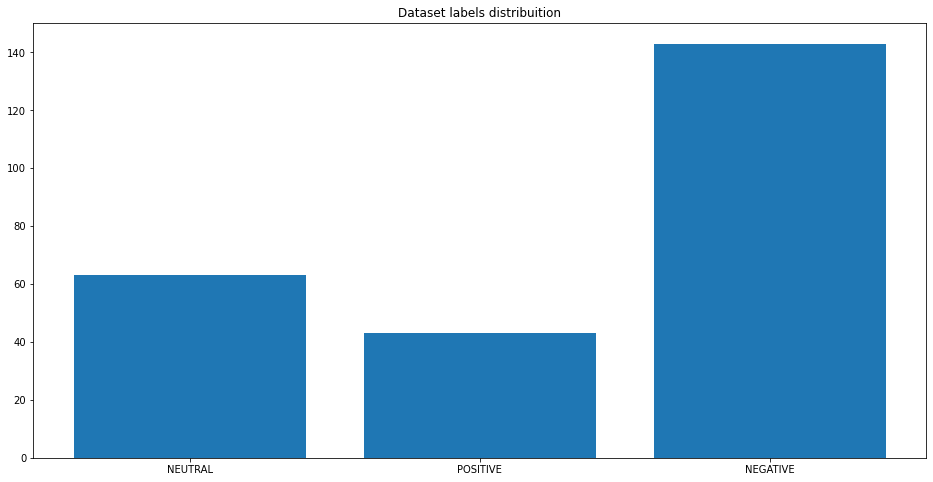

In [9]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [10]:
stop_words = stopwords.words("spanish")
stemmer = SnowballStemmer("spanish")

In [11]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [12]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 17 ms


### Split train and test

In [13]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 199
TEST size: 50


### Word2Vec 

In [14]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 0 ns


In [15]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [16]:
w2v_model.build_vocab(documents)

2020-11-10 18:07:29,424 : INFO : collecting all words and their counts
2020-11-10 18:07:29,424 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-11-10 18:07:29,425 : INFO : collected 939 word types from a corpus of 2225 raw words and 199 sentences
2020-11-10 18:07:29,426 : INFO : Loading a fresh vocabulary
2020-11-10 18:07:29,427 : INFO : effective_min_count=10 retains 27 unique words (2% of original 939, drops 912)
2020-11-10 18:07:29,428 : INFO : effective_min_count=10 leaves 679 word corpus (30% of original 2225, drops 1546)
2020-11-10 18:07:29,428 : INFO : deleting the raw counts dictionary of 939 items
2020-11-10 18:07:29,430 : INFO : sample=0.001 downsamples 27 most-common words
2020-11-10 18:07:29,431 : INFO : downsampling leaves estimated 119 word corpus (17.5% of prior 679)
2020-11-10 18:07:29,432 : INFO : estimated required memory for 27 words and 300 dimensions: 78300 bytes
2020-11-10 18:07:29,432 : INFO : resetting layer weights


In [17]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 27


In [18]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-11-10 18:07:29,502 : INFO : training model with 8 workers on 27 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-11-10 18:07:29,507 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-11-10 18:07:29,508 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-11-10 18:07:29,509 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-11-10 18:07:29,509 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-11-10 18:07:29,510 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-10 18:07:29,510 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-10 18:07:29,511 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-10 18:07:29,511 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-10 18:07:29,512 : INFO : EPOCH - 1 : training on 2225 raw words (112 effective words) took 0.0s, 19958 effective word

Wall time: 335 ms


(3819, 71200)

In [19]:
w2v_model.wv.most_similar("masacre")

2020-11-10 18:07:29,844 : INFO : precomputing L2-norms of word weight vectors


[('atencin', 0.9973305463790894),
 ('nuevamasacre', 0.9972949028015137),
 ('antioquia', 0.9972440004348755),
 ('urgente', 0.9970852732658386),
 ('vez', 0.9970341324806213),
 ('atencion', 0.9968382716178894),
 ('tmesis', 0.9966180920600891),
 ('rt', 0.9965373873710632),
 ('colombia', 0.9962148666381836),
 ('sierra', 0.9960283041000366)]

### Tokenize Text

In [20]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 940
Wall time: 6 ms


In [21]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 6 ms


### Label Encoder 

In [22]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL', 'NEUTRAL']

In [23]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (199, 1)
y_test (50, 1)


In [24]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (199, 300)
y_train (199, 1)

x_test (50, 300)
y_test (50, 1)


In [25]:
y_train[:10]

array([[2],
       [0],
       [0],
       [0],
       [0],
       [2],
       [0],
       [2],
       [1],
       [0]], dtype=int64)

### Embedding layer

In [26]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(940, 300)


In [27]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [28]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          282000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 442,501
Trainable params: 160,501
Non-trainable params: 282,000
_________________________________________________________________


### Compile model

In [29]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2020-11-10 18:07:30,747 : WARNING : From C:\Users\Proyecto\anaconda3\envs\twitter\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Callbacks

In [30]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

### Train

In [31]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

2020-11-10 18:07:31,410 : WARNING : From C:\Users\Proyecto\anaconda3\envs\twitter\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 179 samples, validate on 20 samples
Epoch 1/8
179/179 [==============================] - 1s 6ms/step - loss: 0.6931 - accuracy: 0.4246 - val_loss: 0.6919 - val_accuracy: 0.4500
Epoch 2/8
179/179 [==============================] - 1s 4ms/step - loss: 0.6899 - accuracy: 0.3073 - val_loss: 0.6907 - val_accuracy: 0.4500
Epoch 3/8
179/179 [==============================] - 1s 4ms/step - loss: 0.6854 - accuracy: 0.3017 - val_loss: 0.6893 - val_accuracy: 0.4500
Epoch 4/8
179/179 [==============================] - 1s 4ms/step - loss: 0.6811 - accuracy: 0.3073 - val_loss: 0.6877 - val_accuracy: 0.4500
Epoch 5/8
179/179 [==============================] - 1s 4ms/step - loss: 0.6764 - accuracy: 0.3073 - val_loss: 0.6858 - val_accuracy: 0.4500
Epoch 6/8
179/179 [==============================] - 1s 4ms/step - loss: 0.6711 - accuracy: 0.3073 - val_loss: 0.6833 - val_accuracy: 0.4500
Wall time: 5.46 s


### Evaluate

In [32]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

50/50 [==============================] - 0s 2ms/step

ACCURACY: 0.41999998688697815
LOSS: 0.6758542060852051
Wall time: 91.5 ms


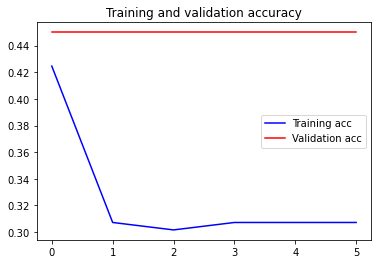

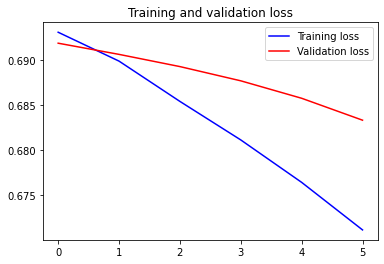

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [34]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [35]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [36]:
predict("Masacre en el cauca deja 10 heridos")

{'label': 'NEUTRAL',
 'score': 0.5147222280502319,
 'elapsed_time': 0.09194326400756836}

In [37]:
predict("Prevencion de la violencia contra la mujer")

{'label': 'NEUTRAL',
 'score': 0.5300931930541992,
 'elapsed_time': 0.021163225173950195}

### Confusion Matrix

In [38]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

50/50 [==============================] - 0s 2ms/step
Wall time: 84.1 ms


In [39]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

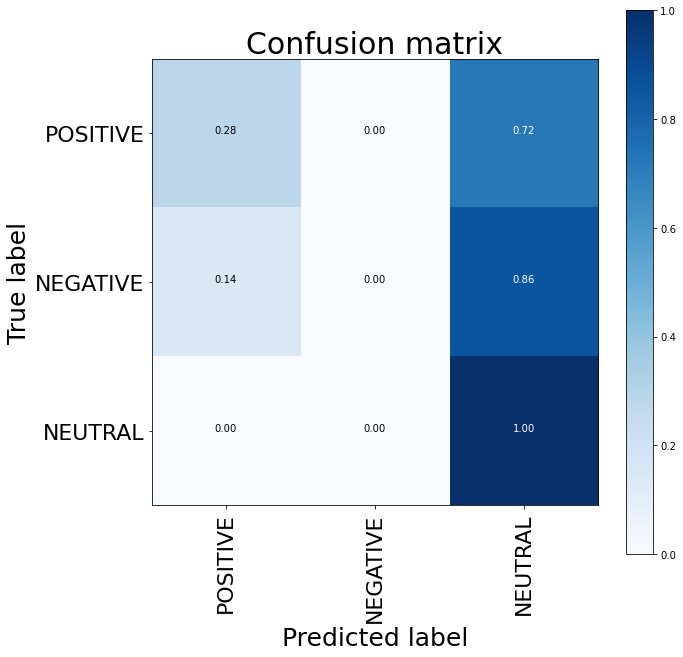

Wall time: 189 ms


In [40]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [41]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.82      0.28      0.42        32
     NEUTRAL       0.00      0.00      0.00        14
    POSITIVE       0.10      1.00      0.19         4

    accuracy                           0.26        50
   macro avg       0.31      0.43      0.20        50
weighted avg       0.53      0.26      0.28        50



C:\Users\Proyecto\anaconda3\envs\twitter\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Accuracy Score

In [42]:
accuracy_score(y_test_1d, y_pred_1d)

0.26

### Save model

In [43]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-11-10 18:07:37,431 : INFO : saving Word2Vec object under model.w2v, separately None
2020-11-10 18:07:37,431 : INFO : not storing attribute vectors_norm
2020-11-10 18:07:37,431 : INFO : not storing attribute cum_table
2020-11-10 18:07:37,431 : INFO : saved model.w2v
